In [197]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
# from catboost import CatBoostClassifier

In [2]:
df = pd.read_excel('/content/bank-marketing-campaigns.csv.xlsx',sheet_name='bank-marketing-campaigns')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [5]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [7]:
df.duplicated().sum()

12

In [8]:
df.drop_duplicates(inplace=True)

In [144]:
X = df.drop(columns=['y'])
y = df['y'].apply(lambda x: 1 if x == 'yes' else 0)  # Binary encoding of target

In [145]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [166]:
# List of categorical and numerical columns
cat_columns = X.select_dtypes(include=['object']).columns.tolist()
num_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [167]:
for col in cat_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

In [168]:

# Pipeline for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', 'passthrough', cat_columns)
    ])

## **XGBoosted model**

### xgb with smote

In [169]:
# XGBoost Model Pipeline with smote
xgb_pipeline_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state=42))
])


In [170]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],        # Number of boosting rounds
    'classifier__max_depth': [3, 6, 9],                # Maximum depth of a tree
    'classifier__learning_rate': [0.01, 0.1, 0.2],     # Step size shrinkage
    # 'subsample': [0.6, 0.8, 1.0],          # Subsample ratio of training instances
    # 'colsample_bytree': [0.6, 0.8, 1.0],   # Subsample ratio of features for each tree
    # 'gamma': [0, 0.1, 0.2],                # Minimum loss reduction to make a further partition on a leaf node
    # 'reg_alpha': [0, 0.01, 0.1],           # L1 regularization term on weights
    # 'reg_lambda': [1, 1.5, 2]              # L2 regularization term on weights
}

grid_search = GridSearchCV(estimator=xgb_pipeline_smote,
                           param_grid=param_grid,
                           cv=5,           # 5-fold cross-validation
                           scoring='accuracy',  # Use 'accuracy' as the scoring metric
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print("Best parameters for xgb smote:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:21:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for xgb smote: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 6, 'classifier__n_estimators': 100}


In [171]:
best_params_xgb_all_smote = grid_search.best_params_
# best_params_xgb_all_smote = {'classifier__' + key: value for key, value in best_params_xgb_all_smote.items()}


In [172]:
xgb_pipeline_smote.set_params(**best_params_xgb_all_smote)
xgb_pipeline_smote.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:21:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat', 'passthrough',
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('smote', SMOT...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [175]:
import joblib
joblib.dump(xgb_pipeline_smote, 'xgb_pipeline_smote.pkl')

# Step 2: Download the model
from google.colab import files
files.download('xgb_pipeline_smote.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [173]:
xgb_pred_smote = xgb_pipeline_smote.predict(X_test)
xgb_acc_smote = accuracy_score(y_test, xgb_pred_smote)
print("XGboost Accuracy with smote:", xgb_acc_smote)

XGboost Accuracy with smote: 0.9110004856726567


In [174]:
report_xgb_smote = classification_report(y_test,xgb_pred_smote)
print(f"Classification Report for xgb with smote:\n{report_xgb_smote}")

Classification Report for xgb with smote:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7265
           1       0.63      0.61      0.62       971

    accuracy                           0.91      8236
   macro avg       0.79      0.78      0.78      8236
weighted avg       0.91      0.91      0.91      8236



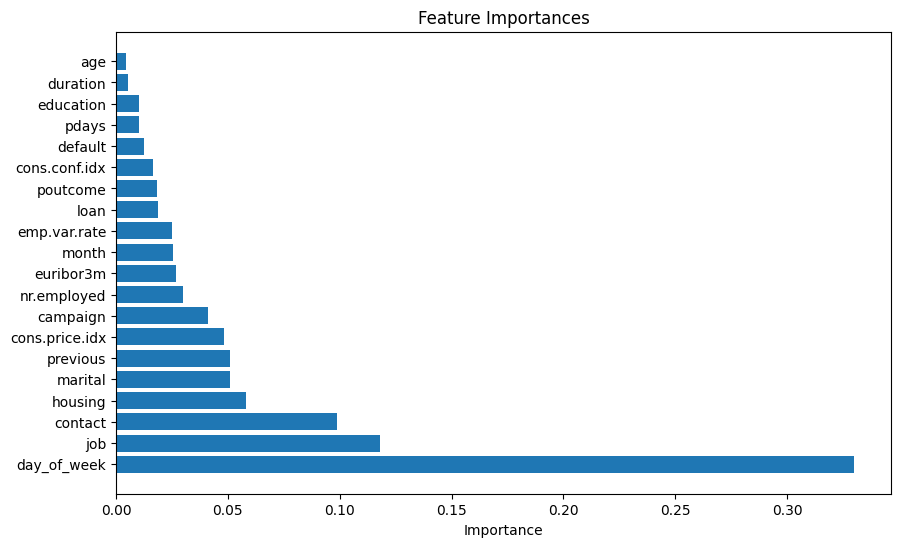

In [178]:
# Get feature importances from the xgb
importances = xgb_pipeline_smote.named_steps['classifier'].feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()


### xgb with class weights

In [157]:
ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [158]:
# xgb pipeline with class weights
xgb_pipeline_weighted = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('classifier', XGBClassifier(scale_pos_weight=ratio,random_state=42))  # Set scale_pos_weight according to class distribution
])

In [159]:
param_grid = {

    'classifier__n_estimators': [50, 100, 200],        # Number of boosting rounds
    'classifier__max_depth': [3, 6, 9],                # Maximum depth of a tree
    'classifier__learning_rate': [0.01, 0.1, 0.2],     # Step size shrinkage
    # 'subsample': [0.6, 0.8, 1.0],          # Subsample ratio of training instances
    # 'colsample_bytree': [0.6, 0.8, 1.0],   # Subsample ratio of features for each tree
    # 'gamma': [0, 0.1, 0.2],                # Minimum loss reduction to make a further partition on a leaf node
    # 'reg_alpha': [0, 0.01, 0.1],           # L1 regularization term on weights
    # 'reg_lambda': [1, 1.5, 2]              # L2 regularization term on weights
}

grid_search = GridSearchCV(estimator=xgb_pipeline_weighted,
                           param_grid=param_grid,
                           cv=5,           # 5-fold cross-validation
                           scoring='accuracy',  # Use 'accuracy' as the scoring metric
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print("Best parameters for xgb weighted:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for xgb weighted: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 9, 'classifier__n_estimators': 200}


In [160]:
best_params_xgb_all_weighted = grid_search.best_params_
# best_params_xgb_all_weighted = {'classifier__' + key: value for key, value in best_params_xgb_all_weighted.items()}


In [161]:
xgb_pipeline_weighted.set_params(**best_params_xgb_all_weighted)
xgb_pipeline_weighted.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat', 'passthrough',
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('classifier'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [176]:
import joblib
joblib.dump(xgb_pipeline_weighted, 'xgb_pipeline_weighted.pkl')

# Step 2: Download the model
from google.colab import files
files.download('xgb_pipeline_weighted.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [163]:
xgb_pred_weighted = xgb_pipeline_weighted.predict(X_test)
xgb_acc_weighted = accuracy_score(y_test, xgb_pred_weighted)
print("XGboost Accuracy with weighted class:", xgb_acc_weighted)

XGboost Accuracy with weighted class: 0.9025012141816415


In [165]:
report_xgb_weighted = classification_report(y_test,xgb_pred_weighted)
print(f"Classification Report for xgb with weighted:\n{report_xgb_weighted}")

Classification Report for xgb with weighted:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      7265
           1       0.57      0.69      0.63       971

    accuracy                           0.90      8236
   macro avg       0.76      0.81      0.78      8236
weighted avg       0.91      0.90      0.91      8236



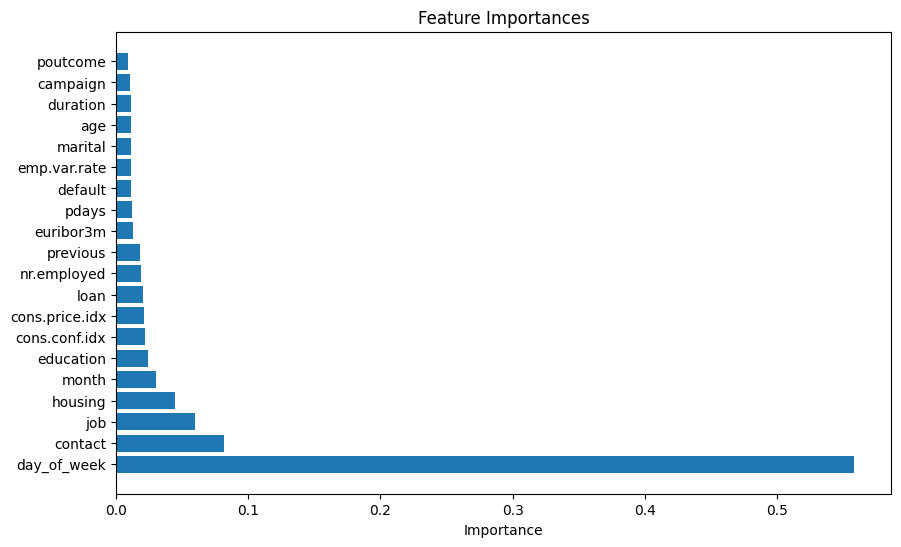

In [179]:
# Get feature importances from the xgb
importances = xgb_pipeline_weighted.named_steps['classifier'].feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

## **Random Forest model**

### Random forest with smote

In [180]:
# Random Forest Model Pipeline with smote
rf_pipeline_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [182]:
from sklearn.model_selection import GridSearchCV

# Example for Random Forest
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf_pipeline_smote, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_search.best_params_)

Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


In [183]:
best_params_rf_all_smote = grid_search.best_params_
# best_params_rf_all_smote = {'classifier__' + key: value for key, value in best_params_rf_all_smote.items()}


In [184]:
rf_pipeline_smote.set_params(**best_params_rf_all_smote)
rf_pipeline_smote.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat', 'passthrough',
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(min_samples_split=5, n_estimators=200,
                                        random_state=42))])

In [188]:
import joblib
joblib.dump(rf_pipeline_smote, 'rf_pipeline_smote.pkl')

# Step 2: Download the model
from google.colab import files
files.download('rf_pipeline_smote.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [185]:
rf_pred_smote = rf_pipeline_smote.predict(X_test)
rf_acc_smote = accuracy_score(y_test, rf_pred_smote)
print("Random Forest Accuracy:", rf_acc_smote)

Random Forest Accuracy: 0.9045653229723166


In [186]:
report_rf_all_smote = classification_report(y_test,rf_pred_smote)
print(f"Classification Report for rf:\n{report_rf_all_smote}")

Classification Report for rf:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7265
           1       0.58      0.67      0.62       971

    accuracy                           0.90      8236
   macro avg       0.77      0.80      0.78      8236
weighted avg       0.91      0.90      0.91      8236



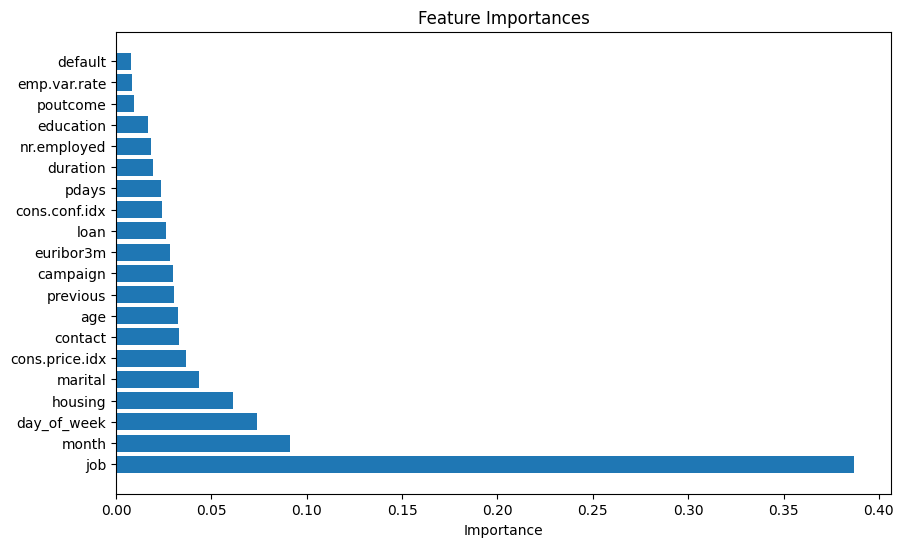

In [187]:
# Get feature importances from the xgb
importances = rf_pipeline_smote.named_steps['classifier'].feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

In [211]:
# Assuming rf is your trained Random Forest model
y_pred_proba = rf_pipeline_smote.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for class 1

# Adjust the threshold (e.g., 0.4 instead of 0.5)
threshold = 0.3
y_pred_thresholded = (y_pred_proba >= threshold).astype(int)

# Evaluate the new predictions
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_thresholded))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7265
           1       0.49      0.88      0.63       971

    accuracy                           0.88      8236
   macro avg       0.74      0.88      0.78      8236
weighted avg       0.92      0.88      0.89      8236



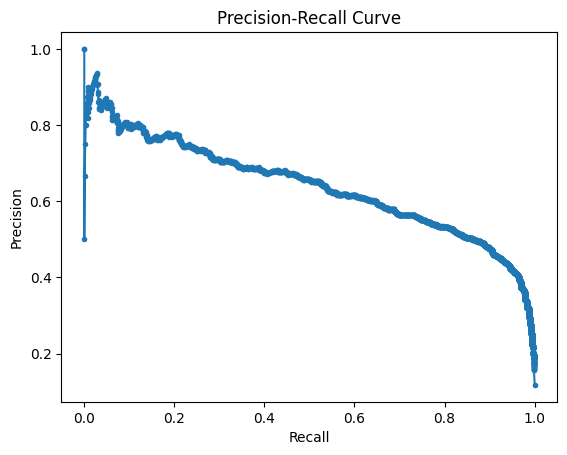

Average Precision Score: 0.640437191736635


In [212]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1
y_pred_proba = rf_pipeline_smote.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot the precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Optionally, print the average precision score
average_precision = average_precision_score(y_test, y_pred_proba)
print(f'Average Precision Score: {average_precision}')


In [213]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [214]:
y_pred_proba = rf_pipeline_smote.predict_proba(X_test)[:, 1]

In [215]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Calculate FPR and TPR

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")

AUC: 0.94


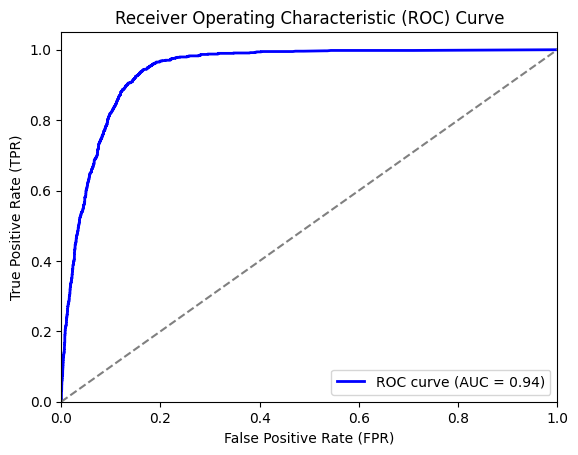

In [216]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Dashed diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## **Logistic regression with smote**

In [189]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_columns)
    ])


In [192]:
from sklearn.linear_model import LogisticRegression
lr_pipeline_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(solver='saga', max_iter=1000,random_state=42))  # Increase max_iter if needed
])

In [193]:
lr_pipeline_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='saga'))])

In [199]:
import joblib
joblib.dump(lr_pipeline_smote, 'lr_pipeline_smote.pkl')

# Step 2: Download the model
from google.colab import files
files.download('lr_pipeline_smote.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [194]:
lr_pred_smote = lr_pipeline_smote.predict(X_test)


In [195]:
lr_acc_smote = accuracy_score(y_test, lr_pred_smote)
print("Logistic regression Accuracy with smote:", lr_acc_smote)

Logistic regression Accuracy with smote: 0.8623118018455561


In [198]:
report_lr = classification_report(y_test,lr_pred_smote)
print(f"Classification Report:\n{report_lr}")

cm_lr = confusion_matrix(y_test,lr_pred_smote)
print(f"Confusion Matrix:\n{cm_lr}")

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7265
           1       0.46      0.87      0.60       971

    accuracy                           0.86      8236
   macro avg       0.72      0.87      0.76      8236
weighted avg       0.92      0.86      0.88      8236

Confusion Matrix:
[[6257 1008]
 [ 126  845]]


## **Custom ensamble method**

In [200]:
from sklearn.ensemble import VotingClassifier

# Assuming rf_pipeline, xgb_pipeline, and logreg_pipeline are the pipelines without SMOTE
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_pipeline_smote),  # Your fitted Random Forest pipeline
        ('xgb', xgb_pipeline_smote),  # Your fitted XGBoost pipeline
        ('logreg', lr_pipeline_smote)  # Your fitted Logistic Regression pipeline
    ],
    voting='soft'  # Change to 'hard' for hard voting
)

In [201]:
voting_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:34:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('rf',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['age',
                                                                                 'duration',
                                                                                 'campaign',
                                                                                 'pdays',
                                                                                 'previous',
                                                                                 'emp.var.rate',
                                                                                 'cons.price.idx',
                                                                                 'cons.conf.idx',
                                                                                 'euribor3m',
                                                                                 'nr.employed']),
                                                                               ('cat',
                                                                                'passthrough',
                                                                                ['job',
                                                                                 'marital',
                                                                                 'education',
                                                                                 'default',
                                                                                 'housing',
                                                                                 'loan',
                                                                                 'contact',
                                                                                 'month',
                                                                                 'day_of_...
                                                                                 'cons.conf.idx',
                                                                                 'euribor3m',
                                                                                 'nr.employed']),
                                                                               ('cat',
                                                                                OneHotEncoder(drop='first',
                                                                                              handle_unknown='ignore',
                                                                                              sparse_output=False),
                                                                                ['job',
                                                                                 'marital',
                                                                                 'education',
                                                                                 'default',
                                                                                 'housing',
                                                                                 'loan',
                                                                                 'contact',
                                                                                 'month',
                                                                                 'day_of_week',
                                                                                 'poutcome'])])),
                                              ('smote', SMOTE(random_state=42)),
                                             

In [205]:
import joblib
joblib.dump(voting_model, 'voting_model_smote.pkl')

# Step 2: Download the model
from google.colab import files
files.download('voting_model_smote.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [202]:
y_pred_voting = voting_model.predict(X_test)

In [203]:
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f"Voting Ensemble Accuracy: {accuracy_voting}")

Voting Ensemble Accuracy: 0.9033511413307431


In [204]:
report_voting = classification_report(y_test,y_pred_voting)
print(f"Classification Report:\n{report_voting}")

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      7265
           1       0.57      0.77      0.65       971

    accuracy                           0.90      8236
   macro avg       0.77      0.85      0.80      8236
weighted avg       0.92      0.90      0.91      8236



## **Comparison of models**

In [206]:
### accuracy of rf and xgb with all the features
print("Random Forest Accuracy smote:", rf_acc_smote)
print("XGboost Accuracy smote:", xgb_acc_smote)

Random Forest Accuracy smote: 0.9045653229723166
XGboost Accuracy smote: 0.9110004856726567


In [209]:
### accuracy of xgb with weighted class
print("XGboost Accuracy weighted:", xgb_acc_weighted)

XGboost Accuracy weighted: 0.9025012141816415


In [207]:
### accuracy of the logistic model with smote
print("Logistic regression accuracy smote:",lr_acc_smote)

Logistic regression accuracy smote: 0.8623118018455561


In [208]:
### accuracy of the ensamble method
print(f"Voting Ensemble Accuracy: {accuracy_voting}")

Voting Ensemble Accuracy: 0.9033511413307431


## _______________________________________________________________________________________________________________________________

## Random Forest best features

In [85]:
# Feature importance for Random Forest
rf_feature_importances = rf_pipeline.named_steps['classifier'].feature_importances_
print("Random Forest Feature Importances:\n", rf_feature_importances)

Random Forest Feature Importances:
 [0.06644997 0.36439022 0.02822902 0.04267242 0.01219141 0.02206509
 0.02614816 0.03448039 0.1122515  0.09414009 0.03247687 0.01523166
 0.02914516 0.00639568 0.01016081 0.00987951 0.01046445 0.02115915
 0.0286098  0.03345866]


In [86]:
from sklearn.feature_selection import RFE

In [87]:
from sklearn.feature_selection import RFE

# Using RandomForest for example
rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=1)
rfe_selector = rfe_selector.fit(X_train, y_train)

# Get the ranking of the features
rfe_ranking = rfe_selector.ranking_

# Show selected features
selected_features_rf = X_train.columns[rfe_selector.support_]
print("Selected Features by RFE:", selected_features_rf)

Selected Features by RFE: Index(['age', 'job', 'education', 'day_of_week', 'duration', 'campaign',
       'poutcome', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')


In [98]:
X_selected_rf = X[selected_features_rf]

In [99]:
# Split the data into training and testing sets
X_train_selected_rf, X_test_selected_rf, y_train_selected_rf, y_test_selected_rf = train_test_split(
    X_selected_rf, y, test_size=0.2, random_state=42
)


In [100]:
X_selected_rf.columns

Index(['age', 'job', 'education', 'day_of_week', 'duration', 'campaign',
       'poutcome', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [101]:
# List of categorical and numerical columns
cat_columns = X_selected_rf.select_dtypes(include=['object']).columns.tolist()
num_columns = X_selected_rf.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [102]:
for col in cat_columns:
    le = LabelEncoder()
    X_train_selected_rf[col] = le.fit_transform(X_train_selected_rf[col].astype(str))
    X_test_selected_rf[col] = le.transform(X_test_selected_rf[col].astype(str))

In [103]:
preprocessor_selected = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),num_columns),
        ('cat', 'passthrough', cat_columns)

    ],

    )


In [104]:
# Random Forest Model Pipeline
rf_pipeline_selected = Pipeline(steps=[
    ('preprocessor', preprocessor_selected),
    ('classifier', RandomForestClassifier())
])

In [105]:
X_train_selected_rf.columns

Index(['age', 'job', 'education', 'day_of_week', 'duration', 'campaign',
       'poutcome', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [47]:
rf_pipeline_selected.fit(X_train_selected_rf, y_train_selected_rf)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'cons.price.idx',
                                                   'euribor3m',
                                                   'nr.employed'])])),
                ('classifier', RandomForestClassifier())])

In [48]:
rf_pred_selected = rf_pipeline_selected.predict(X_test_selected_rf)


In [49]:
rf_acc_selected = accuracy_score(y_test_selected_rf, rf_pred_selected)
print("Random Forest Accuracy (Selected Features):", rf_acc_selected)

Random Forest Accuracy (Selected Features): 0.9082078678970374


In [194]:
from sklearn.model_selection import GridSearchCV

# Example for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train_selected_rf, y_train_selected_rf)

print("Best parameters for Random Forest:", grid_search.best_params_)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}


In [199]:
best_params_rf = grid_search.best_params_
best_params_rf = {'classifier__' + key: value for key, value in best_params_rf.items()}


In [200]:
rf_pipeline_selected.set_params(**best_params_rf)
rf_pipeline_selected.fit(X_train_selected_rf, y_train_selected_rf)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'pdays',
                                                   'cons.price.idx',
                                                   'euribor3m',
                                                   'nr.employed']),
                                                 ('cat', 'passthrough',
                                                  ['job', 'education',
                                                   'day_of_week'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=10,
                                        n_estimators=200))])

In [218]:
import joblib
joblib.dump(rf_pipeline_selected, 'rf_pipeline_selected.pkl')

['rf_pipeline_selected.pkl']

In [219]:
from google.colab import files
files.download('rf_pipeline_selected.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [94]:
rf_pipeline_selected = joblib.load('rf_pipeline_selected.pkl')

In [106]:
rf_pipeline_selected.fit(X_train_selected_rf, y_train_selected_rf)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'duration',
                                                   'campaign', 'cons.conf.idx',
                                                   'euribor3m',
                                                   'nr.employed']),
                                                 ('cat', 'passthrough',
                                                  ['job', 'education',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('classifier', RandomForestClassifier())])

### Evaluation of random forest

In [107]:
rf_pred_selected = rf_pipeline_selected.predict(X_test_selected_rf)
rf_acc_selected = accuracy_score(y_test_selected_rf, rf_pred_selected)
print("Random Forest Accuracy (Selected Features):", rf_acc_selected)

Random Forest Accuracy (Selected Features): 0.9116075764934434


In [202]:
report_rf = classification_report(y_test_selected_rf, rf_pred_selected)
print(f"Classification Report for random forest:\n{report_rf}")

Classification Report for random forest:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7265
           1       0.66      0.53      0.59       971

    accuracy                           0.91      8236
   macro avg       0.80      0.74      0.77      8236
weighted avg       0.91      0.91      0.91      8236



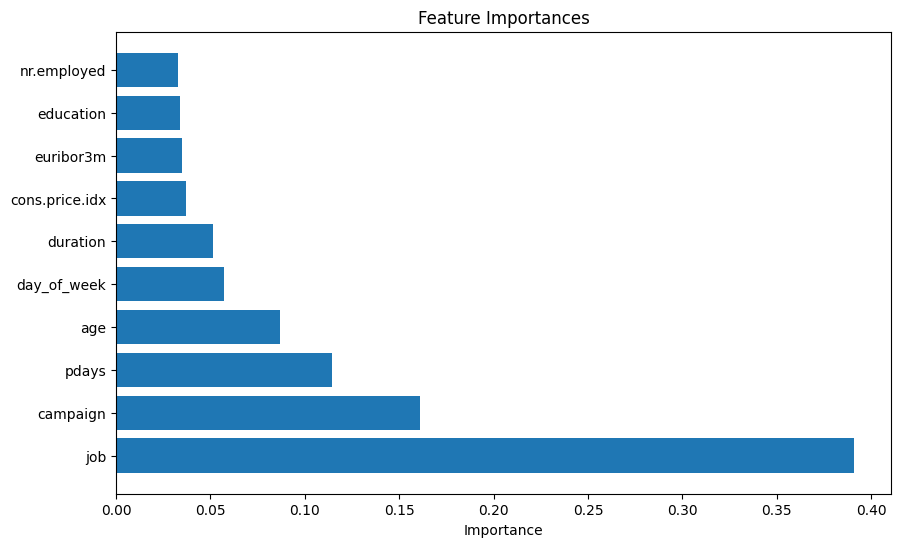

In [203]:
# Get feature importances from the Random Forest
importances = rf_pipeline_selected.named_steps['classifier'].feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_selected_rf.columns,
    'Importance': importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

## xgboost best features

In [72]:
from sklearn.feature_selection import RFE

# Using RandomForest for example
xgb_selector = RFE(estimator=XGBClassifier(), n_features_to_select=10, step=1)
xgb_selector = xgb_selector.fit(X_train, y_train)

# Get the ranking of the features
xgb_ranking = xgb_selector.ranking_

# Show selected features
selected_features_xgb = X_train.columns[xgb_selector.support_]
print("Selected Features by RFE:", selected_features_xgb)

Selected Features by RFE: Index(['default', 'contact', 'month', 'duration', 'pdays', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed'],
      dtype='object')


In [73]:
X_selected_xgb = X[selected_features_xgb]

In [74]:
X_selected_xgb.columns

Index(['default', 'contact', 'month', 'duration', 'pdays', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed'],
      dtype='object')

In [75]:
# Split the data into training and testing sets
X_train_selected_xgb, X_test_selected_xgb, y_train_selected_xgb, y_test_selected_xgb = train_test_split(
    X_selected_xgb, y, test_size=0.2, random_state=42
)

In [76]:
# List of categorical and numerical columns
cat_columns = X_selected_xgb.select_dtypes(include=['object']).columns.tolist()
num_columns = X_selected_xgb.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [77]:
for col in cat_columns:
    le = LabelEncoder()
    X_train_selected_xgb[col] = le.fit_transform(X_train_selected_xgb[col].astype(str))
    X_test_selected_xgb[col] = le.transform(X_test_selected_xgb[col].astype(str))

In [78]:
preprocessor_selected_xgb = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),num_columns),
        ('cat', 'passthrough', cat_columns)

    ])

In [79]:
# XGboost Model Pipeline
xgb_pipeline_selected = Pipeline(steps=[
    ('preprocessor', preprocessor_selected_xgb),
    ('classifier', XGBClassifier())
])

In [186]:
X_test_selected_xgb.columns

Index(['default', 'contact', 'month', 'duration', 'pdays', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed'],
      dtype='object')

In [204]:
param_grid = {
    'n_estimators': [50, 100, 200],        # Number of boosting rounds
    'max_depth': [3, 6, 9],                # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2],     # Step size shrinkage
    # 'subsample': [0.6, 0.8, 1.0],          # Subsample ratio of training instances
    # 'colsample_bytree': [0.6, 0.8, 1.0],   # Subsample ratio of features for each tree
    # 'gamma': [0, 0.1, 0.2],                # Minimum loss reduction to make a further partition on a leaf node
    # 'reg_alpha': [0, 0.01, 0.1],           # L1 regularization term on weights
    # 'reg_lambda': [1, 1.5, 2]              # L2 regularization term on weights
}

grid_search = GridSearchCV(estimator=XGBClassifier(),
                           param_grid=param_grid,
                           cv=5,           # 5-fold cross-validation
                           scoring='accuracy',  # Use 'accuracy' as the scoring metric
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X_train_selected_xgb, y_train_selected_xgb)
print("Best parameters for Random Forest:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for Random Forest: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [210]:
best_params_xgb = grid_search.best_params_
best_params_xgb = {'classifier__' + key: value for key, value in best_params_xgb.items()}


In [211]:
xgb_pipeline_selected.set_params(**best_params_xgb)
xgb_pipeline_selected.fit(X_train_selected_xgb, y_train_selected_xgb)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['duration', 'pdays',
                                                   'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx',
                                                   'nr.employed']),
                                                 ('cat', 'passthrough',
                                                  ['default', 'contact',
                                                   'month', 'poutcome'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [216]:
import joblib
joblib.dump(xgb_pipeline_selected, 'xgb_pipeline_selected.pkl')

['xgb_pipeline_selected.pkl']

In [217]:
from google.colab import files
files.download('xgb_pipeline_selected.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
xgb_pipeline_selected = joblib.load('xgb_pipeline_selected.pkl')

In [81]:
xgb_pipeline_selected.fit(X_train_selected_xgb, y_train_selected_xgb)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['duration', 'pdays',
                                                   'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx',
                                                   'nr.employed']),
                                                 ('cat', 'passthrough',
                                                  ['default', 'contact',
                                                   'month', 'poutcome'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

### Evaluation of XGBoost

In [82]:
xgb_pred_selected = xgb_pipeline_selected.predict(X_test_selected_xgb)
xgb_acc_selected = accuracy_score(y_test_selected_xgb, xgb_pred_selected)
print("XGboost Accuracy (Selected Features):", xgb_acc_selected)

XGboost Accuracy (Selected Features): 0.9112433220009714


In [213]:
report_xgb = classification_report(y_test_selected_xgb,xgb_pred_selected)

In [214]:
print(f"Classification Report for XGBoost:\n{report_xgb}")

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7265
           1       0.68      0.51      0.58       971

    accuracy                           0.91      8236
   macro avg       0.81      0.74      0.77      8236
weighted avg       0.91      0.91      0.91      8236



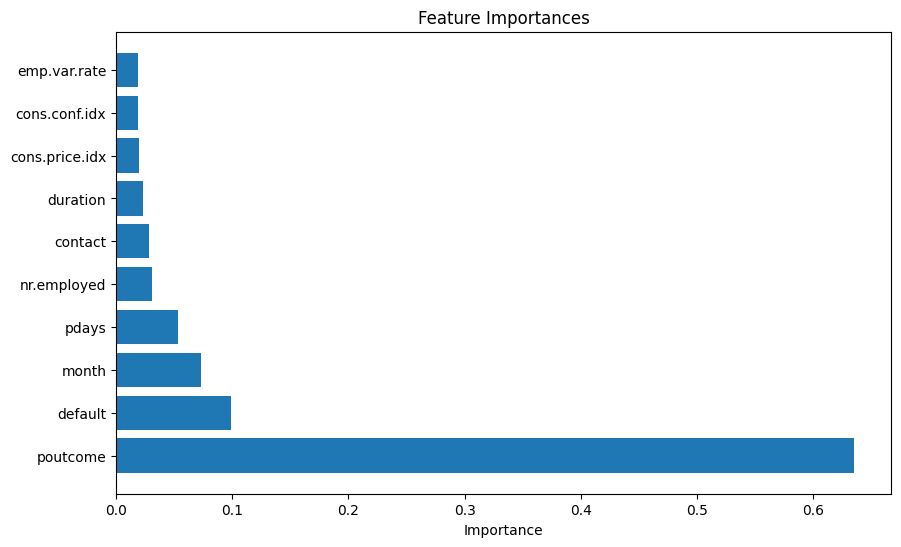

In [215]:
# Get feature importances from the Random Forest
importances = xgb_pipeline_selected.named_steps['classifier'].feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_selected_xgb.columns,
    'Importance': importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()
